In [23]:
import tensorflow as tf
import numpy as np
from memory import Memory
from basics import Basics
from tqdm import tqdm


from networks_kennedy import QN_l1, QN_guess_kennedy
import give_probability_kennedy




basics = Basics(layers=1)
basics.define_actions()
b =np.load("buffer.npy", allow_pickle=True)
buffer = Memory(len(b), load_path=None)
for i in range(len(b)):
    buffer.add_sample(tuple(b[i]))


W1108 21:39:12.026978 139891461576512 base_layer.py:1865] Layer qn_l1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W1108 21:39:12.079481 139891461576512 base_layer.py:1865] Layer qn_l1_1 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to fl

In [30]:
def learn_batch(TAU, networks , batch_length, optimizers):
    batch = buffer.sample(batch_length)
    qn_l1_prim, qn_l1_targ, qn_guess_prim, qn_guess_targ = networks

    outcome_1_beta1_batch = np.array([[ int(v[0]), v[1]] for v in batch ] )
    labels_beta1 = np.array([int(v[2]) for v in batch])

    q_guess_prim = qn_guess_prim(np.expand_dims(outcome_1_beta1_batch, axis=0))
    q_guess_prim = np.squeeze(q_guess_prim.numpy())

    opt_a_2_prim = np.argmax(q_guess_prim,axis=1)

    update_for_q_1_prim = qn_l1_targ(np.expand_dims(np.array([[] for i in range(len(batch))]), axis=0)) #targ = target
    update_for_q_1_prim = np.squeeze(update_for_q_1_prim, axis=0)
    qlabels_l1 = update_for_q_1_prim.copy()

    # print(qlabels_l1.shape, type(qlabels_l1), batch_length, np.arange(batch_length))
    np.save("labelsbeta1", labels_beta1)
    qlabels_l1[np.arange(batch_length), labels_beta1] = np.squeeze(qn_guess_targ(np.expand_dims(outcome_1_beta1_batch, axis=0)).numpy())[np.arange(batch_length),opt_a_2_prim]

    optimizer_ql1, optimizer_guess = optimizers

    train_vars_in = [ch.numpy() for ch in qn_l1_prim.trainable_variables]

    # print(qlabels_l1)
    with tf.device("/cpu:0"):
        with tf.GradientTape() as tape:
            tape.watch(qn_l1_prim.trainable_variables)
            pred_q_1s = qn_l1_prim(np.expand_dims(np.array([[] for i in range(len(batch))]), axis=0))

            loss_sum =tf.keras.losses.MSE(pred_q_1s, qlabels_l1)
            loss = tf.reduce_mean(loss_sum)
            grads = tape.gradient(loss, qn_l1_prim.trainable_variables)
            optimizer_ql1.apply_gradients(zip(grads, qn_l1_prim.trainable_variables))

        s_3_batch = np.array([[int(v[0]), v[1] ] for v in batch])
        rewards = np.array([v[-1] for v in batch])
        labels_guess = np.array([int(v[-2]) for v in batch])

        update_for_q_3_prim = qn_guess_targ(np.expand_dims(s_3_batch, axis=0))
        update_for_q_3_prim = np.squeeze(update_for_q_3_prim, axis=0)
        qlabels_l3 = update_for_q_3_prim.copy()
        qlabels_l3[np.arange(batch_length), labels_guess] = rewards[np.arange(batch_length)]


        with tf.GradientTape() as tape:
            tape.watch(qn_guess_prim.trainable_variables)
            pred_q_3s = qn_guess_prim(np.expand_dims(s_3_batch, axis=0))
            loss_sum =tf.keras.losses.MSE(pred_q_3s, qlabels_l3)
            loss = tf.reduce_mean(loss_sum)
            loss_guess = loss
            grads = tape.gradient(loss, qn_guess_prim.trainable_variables)
            optimizer_guess.apply_gradients(zip(grads, qn_guess_prim.trainable_variables))

        for t, e in zip(qn_l1_targ.trainable_variables, qn_l1_prim.trainable_variables):
            t.assign(t*(1-TAU) + e*TAU)

        for t, e in zip(qn_guess_targ.trainable_variables, qn_guess_prim.trainable_variables):
            t.assign(t*(1-TAU) + e*TAU)
    return loss, loss_guess


In [45]:

LR=0.0005
TAU=0.0005


qn_l1_prim = QN_l1(basics.actions[0])
qn_l1_targ = QN_l1(basics.actions[0])
qn_guess_prim = QN_guess_kennedy(basics.possible_phases)
qn_guess_targ = QN_guess_kennedy(basics.possible_phases)

qvalues1 = qn_l1_prim(np.expand_dims(np.array([]), axis=0))
qvalues1targ = qn_l1_targ(np.expand_dims(np.array([]), axis=0))
qvalueslayerguess_prim = qn_guess_prim(np.expand_dims(np.array([1,-.7]), axis=0))
qvalueslayerguess_targ = qn_guess_targ(np.expand_dims(np.array([1,-.7]), axis=0))

optimizer = tf.keras.optimizers.SGD(lr=LR)
optimizer_guess = tf.keras.optimizers.SGD(lr=LR)

networks = [qn_l1_prim, qn_l1_targ, qn_guess_prim, qn_guess_targ]
optimizers = [optimizer, optimizer_guess]

qn_l1_prim.give_first_beta(epsilon=1)
qn_l1_targ.give_first_beta(epsilon=1)
qn_guess_prim.give_guess([0, -.7], epsilon=1)
qn_guess_targ.give_guess([0, -.7], epsilon=1)

loss_l1 = []
loss_guess = []
for epoch in range(10**6):
    if epoch%10**2 == 1:
        print("episode: ",epoch )
        print("loss_l1: ",loss_l1[-1])
        print("loss_guess: ",loss_guess[-1])
    losses = learn_batch(TAU, networks, 10000, optimizers)
    loss_l1.append(losses[0])
    loss_guess.append(losses[1])


W1108 22:09:16.989151 139891461576512 base_layer.py:1865] Layer qn_l1_10 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

W1108 22:09:17.003111 139891461576512 base_layer.py:1865] Layer qn_l1_11 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults t

episode:  1
loss_l1:  tf.Tensor(0.35994396, shape=(), dtype=float32)
loss_guess:  tf.Tensor(0.35994396, shape=(), dtype=float32)
episode:  101
loss_l1:  tf.Tensor(0.36067376, shape=(), dtype=float32)
loss_guess:  tf.Tensor(0.36067376, shape=(), dtype=float32)
episode:  201
loss_l1:  tf.Tensor(0.36235538, shape=(), dtype=float32)
loss_guess:  tf.Tensor(0.36235538, shape=(), dtype=float32)
episode:  301
loss_l1:  tf.Tensor(0.35314012, shape=(), dtype=float32)
loss_guess:  tf.Tensor(0.35314012, shape=(), dtype=float32)
episode:  401
loss_l1:  tf.Tensor(0.35525572, shape=(), dtype=float32)
loss_guess:  tf.Tensor(0.35525572, shape=(), dtype=float32)
episode:  501
loss_l1:  tf.Tensor(0.35585225, shape=(), dtype=float32)
loss_guess:  tf.Tensor(0.35585225, shape=(), dtype=float32)
episode:  601
loss_l1:  tf.Tensor(0.36008358, shape=(), dtype=float32)
loss_guess:  tf.Tensor(0.36008358, shape=(), dtype=float32)
episode:  701
loss_l1:  tf.Tensor(0.36376137, shape=(), dtype=float32)
loss_guess:  t

KeyboardInterrupt: 

In [47]:
qvalues1 = qn_l1_prim(np.expand_dims(np.array([]), axis=0))


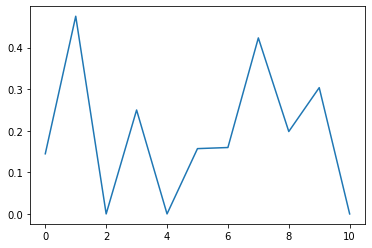

In [53]:
plt.plot(qvalues1.numpy()[0])

ValueError: x and y must have same first dimension, but have shapes (1000,) and (5812,)

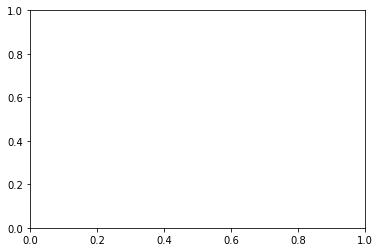

In [46]:
import matplotlib.pyplot as plt

times = np.arange(10**3)
plt.plot(times, loss_guess)
plt.show()